In [20]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [7]:
#get the path to the images
path = '/media/juan/juan1/pyimage_univ/bounding_box/bounding-box-regression/dataset/images/'

In [3]:
#Load the contents of the .csv files
rows = open('/media/juan/juan1/pyimage_univ/bounding_box/bounding-box-regression/dataset/airplanes.csv').read().strip().split('\n')

In [5]:
rows[0]

'image_0001.jpg,49,30,349,137'

In [6]:
#Initialize empty lists to store the images, tarfeg predictions (bounding box (bb) coordinates) and the filenames
data = []
targets = []
filenames = []

#### preprocess the images, obtain labels and filenames

In [8]:
#loop through tge rows and obtain the data

for row in rows:
    row = row.split(',')
    (filename, startX, startY, endX, endY) = row

    #get the filename and open it with cv2
    imagePath = os.path.sep.join([path, filename])
    #read the image to get its shape
    image = cv2.imread(imagePath)
    #get the image dimentions
    h, w = image.shape[:2]

    #Scale the coordinates to 0-1 range
    startX = float(startX)/w
    startY = float(startY)/h
    endX = float(endX)/w
    endY = float(endY)/h

    #Load the image and preprocess it
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)

    #Update the list of data, targets and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [9]:
#Scale the input images to 0-1 scale and convert the coordinates to a numpy array
data = np.array(data, dtype="float32")/255.0
targets = np.array(targets, dtype="float32")

#### Split the data

In [10]:
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

In [11]:
split

[array([[[[0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          [0.46666667, 0.5411765 , 0.6       ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[0.77254903, 0.6901961 , 0.62352943],
          [0.72549

In [13]:
#Unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [14]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
f = open("/media/juan/juan1/pyimage_univ/bounding_box/bounding-box-regression/output/test_images.txt", "w")
f.write('\n'.join(testFilenames))
f.close()

#### Prepare and train the model

In [15]:
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

58889256/58889256 [==============================] - 1s 0us/step


In [16]:
#Freeze the layers so they are not updated
vgg.trainable = False

In [17]:
#Flatten the max poooling output of vgg
flatten = vgg.output
flatten = Flatten()(flatten)

In [18]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation='relu')(flatten)
bboxHead = Dense(64, activation='relu')(bboxHead)
bboxHead = Dense(32, activation='relu')(bboxHead)
#we us 4 since we are getting the 4 coordinates of the bb
bboxHead = Dense(4, activation='relu')(bboxHead)

#register the model
model = Model(inputs=vgg.input, outputs=bboxHead)

In [23]:
opt = Adam(learning_rate = 1e-4)
model.compile(loss='mse', optimizer=opt) #no accuracy since the task doesnt need it

In [24]:
H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=20, verbose=1)

Epoch 1/20
23/23 [==============================] - 13s 346ms/step - loss: 0.0439 - val_loss: 0.0204
Epoch 2/20
23/23 [==============================] - 6s 282ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 3/20
23/23 [==============================] - 6s 278ms/step - loss: 0.0169 - val_loss: 0.0174
Epoch 4/20
23/23 [==============================] - 6s 279ms/step - loss: 0.0164 - val_loss: 0.0173
Epoch 5/20
23/23 [==============================] - 6s 277ms/step - loss: 0.0162 - val_loss: 0.0173
Epoch 6/20
23/23 [==============================] - 7s 288ms/step - loss: 0.0160 - val_loss: 0.0172
Epoch 7/20
23/23 [==============================] - 7s 287ms/step - loss: 0.0158 - val_loss: 0.0171
Epoch 8/20
23/23 [==============================] - 6s 282ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 9/20
23/23 [==============================] - 7s 284ms/step - loss: 0.0156 - val_loss: 0.0172
Epoch 10/20
23/23 [==============================] - 7s 285ms/step - loss: 0.0156 - val_loss: 0.017

In [26]:
model.save('/media/juan/juan1/pyimage_univ/bounding_box/bounding-box-regression/model1.h5', save_format="h5")

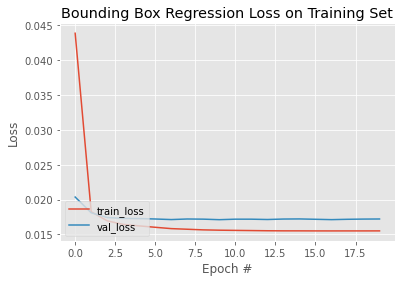

In [28]:
N = 20
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()